In [1]:
import numpy as np
import scipy.optimize as opt
from scipy.stats import norm
from matplotlib import pyplot as plt
import pandas as pd
from NBinomRandomDataGenerator import NBinomRandomDataGenerator
import warnings

# Random Data Generation

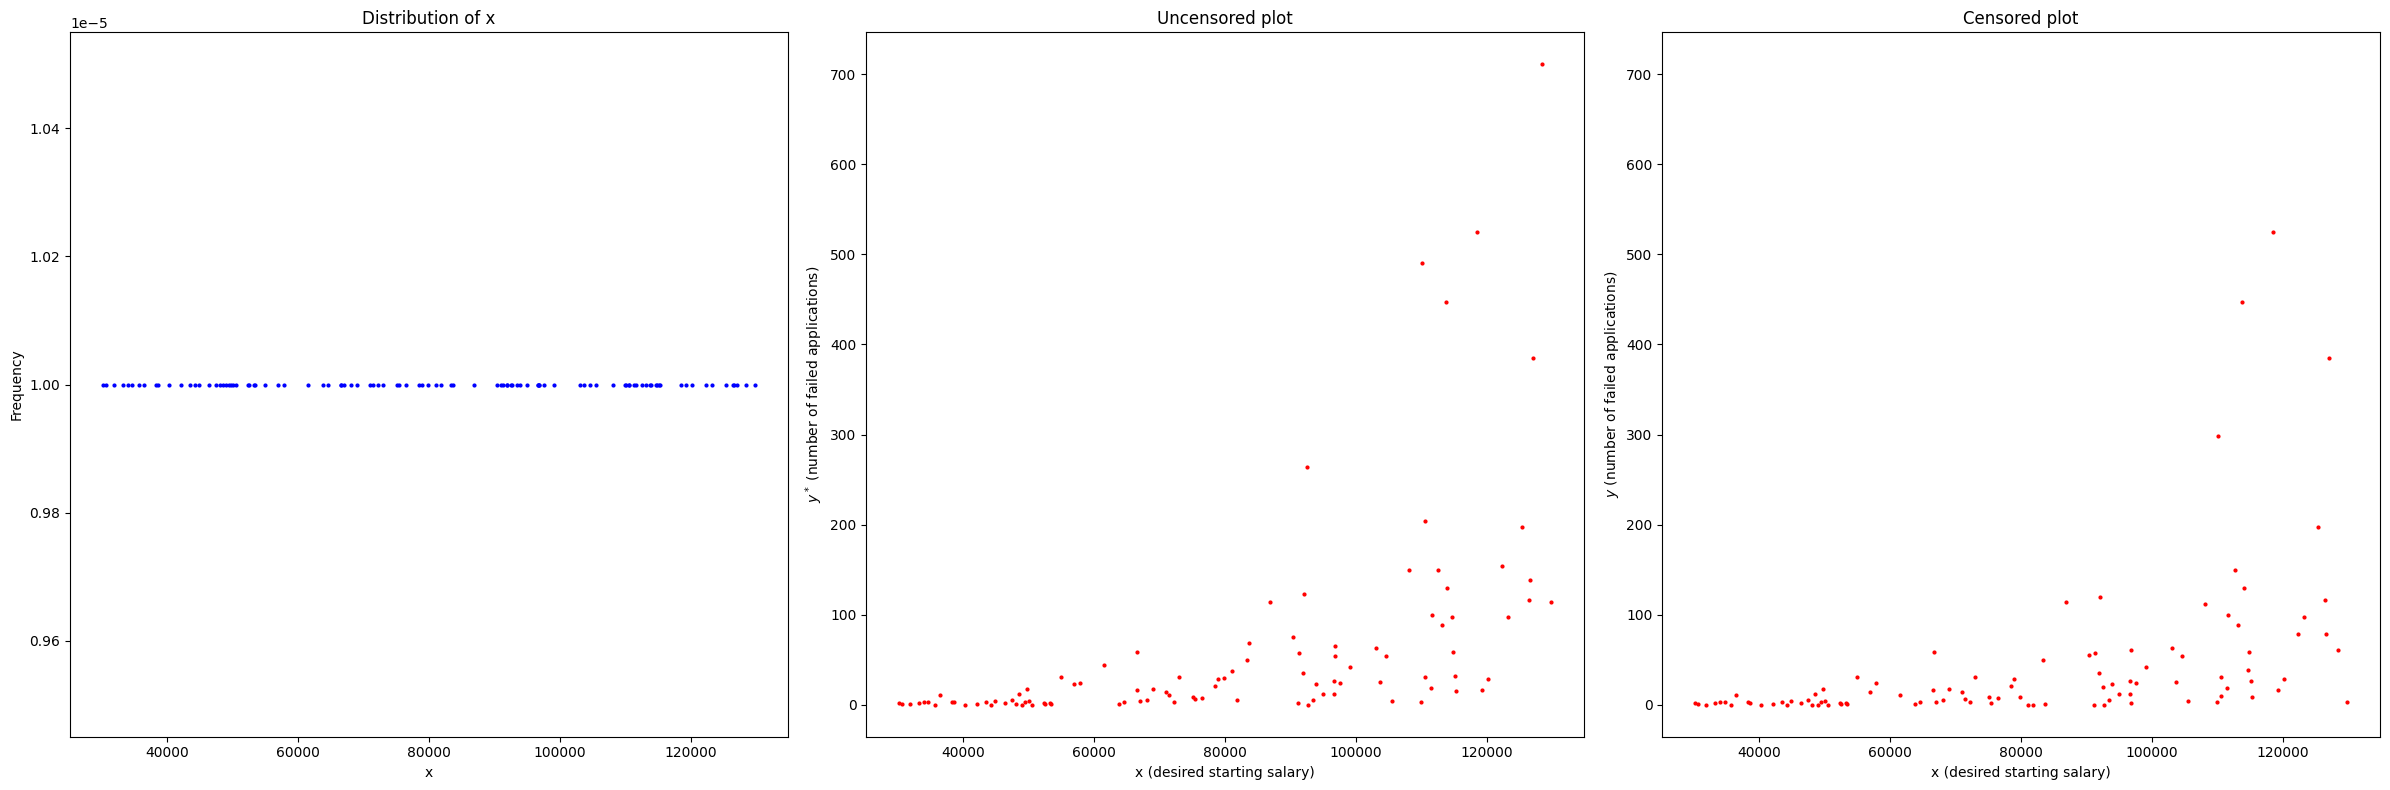

True beta value: [[ 0.e+00 -4.e-05]]


,Desired Starting Salary ($),Rejected Job Applications,Censored
0,33957,3,0
1,64548,3,0
2,44822,4,0
3,109975,3,0
4,50079,4,0
...,...,...,...
95,46372,2,0
96,75109,9,0
97,53357,1,0
98,75449,2,1


In [2]:
randomData = NBinomRandomDataGenerator(size=100, x_distribution='uniform', beta=np.array([0, -4e-5]))
data = randomData.createVaryingCensoredData(generate_plots=True)
print(f"True beta value: {randomData.beta}")
data

In [3]:
# Organize data
x = data["Desired Starting Salary ($)"]
y = data["Rejected Job Applications"]
T = y.copy()
T[data['Censored'] == 0] = y + 1 # If there is no censoring, all that matters is T > y

# Maximum Likelihood Estimation

In [13]:
def nbinom_likelihood(b, x, y, T):
    """x, y, T are numpy arrays or pandas series of length n"""

    def summation(p, T):
        return np.sum([((1-p)**a) * (p) for a in range(T)])

    xb = b[0] + b[1]*x
    p = (np.exp(xb) / (np.exp(xb) + 1)).fillna(1) # The fillna truncates overflow errors when xb is large
    
    sum = np.array([summation(pi, Ti) for pi, Ti in zip(p, T)])
    censored_point = (y == T).astype(int)
    Q = ((1-censored_point) * (np.log(p) + y * np.log(1-p))).fillna(0) +  (censored_point * np.log(1 - sum)).fillna(0) # nan's are filled with zeros, because it likely means that point isn't censored.

    out = -1*np.mean(Q)
    if np.isinf(out):
        out = 1e10
    return out

In [24]:
warnings.simplefilter('ignore')
bounds = ((-1, 1),(-1, 1))
# This minimizer works a lot better, but it's really sensitive to initial conditions. Also, b0 can be a bit off

sol = opt.differential_evolution(nbinom_likelihood, x0=np.array([0, -0.005]), bounds=bounds, args=(x, y, T)) # maxiter=int(1e12)
print(sol)
beta_negbin = sol.x
beta_negbin

             message: Optimization terminated successfully.
             success: True
                 fun: 3.053223090231969
                   x: [ 5.546e-01 -4.893e-05]
                 nit: 42
                nfev: 1335
          population: [[ 5.546e-01 -4.894e-05]
                       [ 7.630e-01 -5.100e-05]
                       ...
                       [ 5.231e-01 -4.879e-05]
                       [ 5.787e-01 -4.971e-05]]
 population_energies: [ 3.053e+00  3.054e+00 ...  3.054e+00  3.054e+00]
                 jac: [-4.760e-03  4.802e-02]


array([ 5.54587910e-01, -4.89281824e-05])

## Marginal Effects: True Distribution

In [7]:
def E_Y(b, x): # The expected value of Y, given beta and x
    return np.exp(-1*(b[0] + b[1]*x))

def d_E_Y(b,x):
    return -1*b[1] * np.exp(-1*(b[0] + b[1]*x))

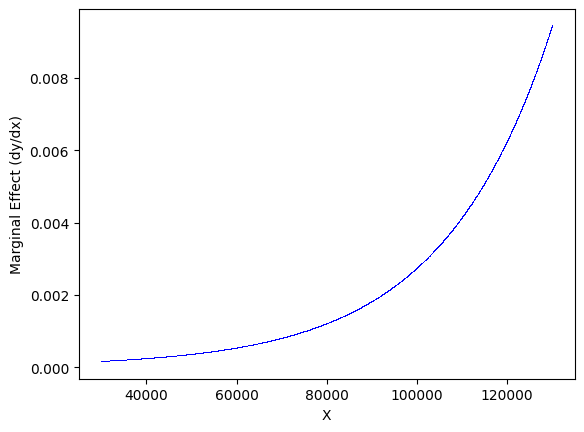

In [8]:
me_negbin = d_E_Y(beta_negbin, x)
plt.plot(x, me_negbin, 'b,')
plt.xlabel("X")
plt.ylabel("Marginal Effect (dy/dx)")

plt.show()

## Marginal Effects: Tobit Model

In [10]:
def tobit_likelihood(b, x, y, T):
    """x, y, T are numpy arrays or pandas series of length n"""

    xb = b[1] + b[2]*x

    censored_point = (y == T).astype(int)
    Q = ((1-censored_point) * (np.log((1/b[0]) * norm.pdf((y - xb) / b[0])))).fillna(0) +  (censored_point * np.log(1 - norm.cdf((y - xb) / b[0]))).fillna(0) # nan's are filled with zeros, because it likely means that point isn't censored.

    out = -1*np.mean(Q)
    if np.isinf(out):
        out = 1e10
    return out


In [11]:
tobit_likelihood(b=np.array([100, 0.5, 1e-5]), x=x, y=y, T=T)

4.554058207584625

In [12]:
warnings.simplefilter('ignore')
bounds = ((0, 500),(-1, 1), (-1,1)) # TODO: What should these bounds even be?
# This minimizer works a lot better, but it's really sensitive to initial conditions. Also, b0 can be a bit off

# b0 is std_dev, b1 is beta0, b2 is beta1

sol = opt.differential_evolution(tobit_likelihood, x0=np.array([100, 0.5, 0.5]), bounds=bounds, args=(x, y, T), maxiter=int(1e12))
print(sol)
beta_tobit = sol.x
beta_tobit
# In this case the marginal effect is just b[2]?

me_tobit = pd.DataFrame(np.ones_like(x)) * beta_tobit[2]
me_tobit

             message: Optimization terminated successfully.
             success: True
                 fun: 4.25871378522339
                   x: [ 7.621e+01 -5.306e-01  8.359e-04]
                 nit: 22
                nfev: 1111
          population: [[ 7.621e+01 -5.306e-01  8.359e-04]
                       [ 7.428e+01  1.241e-01  1.407e-03]
                       ...
                       [ 7.332e+01 -1.220e-01  7.723e-04]
                       [ 7.763e+01 -5.433e-01  8.383e-04]]
 population_energies: [ 4.259e+00  4.446e+00 ...  4.261e+00  4.259e+00]
                 jac: [ 4.411e-04  9.322e-04  3.083e+00]


,0
0,0.000836
1,0.000836
2,0.000836
3,0.000836
4,0.000836
...,...
9995,0.000836
9996,0.000836
9997,0.000836
9998,0.000836


# Comparing Marginal Effects

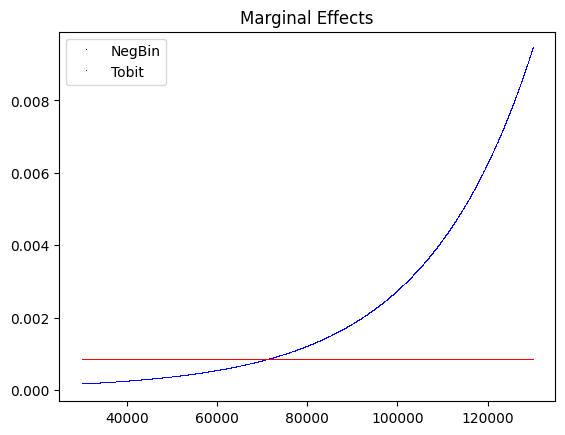

In [13]:
plt.title("Marginal Effects")
plt.plot(x, me_negbin, 'b,', label="NegBin")
plt.plot(x, me_tobit, 'r,', label="Tobit")
plt.legend()
plt.show()

# Inference

In [19]:
# Estimate the Hessian
# The Hessian is the second derivative of Q
from autograd import hessian
import numpy as np
import autograd.numpy as anp

x_ = anp.array(x)
y_ = anp.array(y)
T_ = anp.array(T)

def nbinom_likelihood1(b):
    """x, y, T are numpy arrays or pandas series of length n"""

    def summation(p, T):
        return anp.sum([((1-p)**a) * (p) for a in range(T)])

    xb = b[0] + b[1]*x_
    p = (anp.exp(xb) / (anp.exp(xb) + 1)) # The fillna truncates overflow errors when xb is large
    p = anp.where(anp.isnan(p), 1, p)
    
    sum = anp.array([summation(pi, Ti) for pi, Ti in zip(p, T_)])
    censored_point = (y_ == T_).astype(int)
    # print(censored_point)
    first_part = ((1-censored_point) * (anp.log(p) + y_ * anp.log(1-p)))
    second_part = censored_point * anp.log(1 - sum)
    Q = anp.where(anp.isnan(first_part), 0, first_part) +  anp.where(anp.isnan(second_part), 0, second_part) # nan's are filled with zeros, because it likely means that point isn't censored.

    out = anp.mean(Q)
    if anp.isinf(out):
        out = 1e10
    return out

hessy = hessian(nbinom_likelihood1)
H = hessy(anp.array([0, -4e-5])) # TODO: Replace this array with the nbinom estimate
print(nbinom_likelihood1(np.array([0, -4e-5])))
print(nbinom_likelihood(np.array([0, -4e-5]), x, y, T))

-3.089114617091561
3.089114617091561


In [21]:
import scipy.linalg as la
V = -1*la.inv(H) # TODO: This is definitely wrong... maybe I've got one too many negatives with the argmin reversal. I think that's what it is
V

array([[ 1.28392542e+01, -1.34784193e-04],
       [-1.34784193e-04,  1.56714788e-09]])

In [38]:
# Wald test. Let's test that \beta_1 is not zero
from scipy.stats import chi2

v1 = V[1,1]
b1 = beta_negbin[1]
n = 100
alpha = 0.05

W = (b1 / (np.sqrt(v1 * (1/n))))**2
p = 1 - chi2.cdf(x=W, df=1)

print(f"Wald Statistic: {W}")
print(f"p value: {p}")

if p < alpha:
    print("Significance found: H_0 rejected")
else:
    print("Failed to reject")

Wald Statistic: 152.7594847635483
p value: 0.0
Significance found: H_0 rejected
